# Stochastic Gradient from scratch

In [4]:
%matplotlib inline
from fastai.basics import *

## MNIST SGD

We will get the pickle MNIST dataset from [deeplearning.net/data/mnist/mnist.pkl.gz](deeplearning.net/data/mnist/mnist.pkl.gz). We're going to treatit as a standard flat dataset

In [5]:
#let get the default path for the library

path = Config().data_path()/'mnist'
path.ls()

[PosixPath('/home/anass/.fastai/data/mnist/mnist.pkl.gz')]

In [6]:
with gzip.open(path/'mnist.pkl.gz') as f:
    ((X_train, y_train), (X_valid,y_valid),_) = pickle.load(f,encoding='latin-1')

(-0.5, 27.5, 27.5, -0.5)

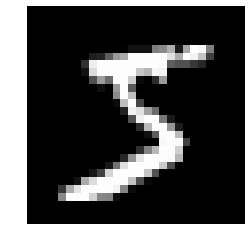

In [7]:
plt.imshow(X_train[0].reshape((28,28)),cmap='gray')
plt.axis('off')

In [8]:
# Let's transform everything to a tensor

X_train, y_train, X_valid, y_valid = map(torch.tensor, (X_train, y_train, X_valid, y_valid))

In [9]:
n, c = X_train.shape
print(f"n = {n}, c  ={c}")
print(X_train.shape, y_train.min(), y_train.max())

n = 50000, c  =784
torch.Size([50000, 784]) tensor(0) tensor(9)


## torch Dataset

Let's create a [Dataset](https://pytorch.org/docs/stable/data.html) from the existing tensors

In [10]:
bs = 64             #batach size
train_ds = TensorDataset(X_train, y_train)
valid_ds  = TensorDataset(X_valid, y_valid)
print(train_ds)

Now let's create a `DataBunch` (which is a custom DataLoader) for our dataset

In [11]:
data = DataBunch.create(train_ds, valid_ds, bs = bs)
print(data)

DataBunch;

Train: <torch.utils.data.dataset.TensorDataset object at 0x7f3fe09c2c18>;

Valid: <torch.utils.data.dataset.TensorDataset object at 0x7f3fe09c2a20>;

Test: None


Let's say we want a simple example from this dataset. Since it's a generator, we will use the method `next` to seek an image

In [12]:
example,label = next(iter(data.train_dl))
print(example.shape, label.shape)

torch.Size([64, 784]) torch.Size([64])


## MNIST_Logistic

Now let's create our own model for a simple *logistic classifier*. the model will inherith from the class `torch.nn.Module` wichi is a [base Model](https://pytorch.org/docs/stable/nn.html) and will use
a linear dense layer with size $(784,10)$

```python
import torch.nn as nn
import torch.nn.functional as F

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5)
        self.conv2 = nn.Conv2d(20, 20, 5)

    def forward(self, x):
       x = F.relu(self.conv1(x))
       return F.relu(self.conv2(x))
```

In [13]:
class Mnist_Logistic(nn.Module):
    """
    Simple model for logistic classification
    """
    def __init__(self):
        super().__init__()
        
        self.lin1 = nn.Linear(784, 10, bias=True)
    
    def forward(self,x):
        return self.lin1(x)
    
    

In [14]:
#tansfer the model to cuda memory
model = Mnist_Logistic().cuda()
print(model)

Mnist_Logistic(
  (lin1): Linear(in_features=784, out_features=10, bias=True)
)


In [15]:
model(example).shape   # image for each image in the batch

torch.Size([64, 10])

Let's print the shape of each parameter in our model

In [50]:
[p.shape for p in model.parameters()]

[torch.Size([10, 784]), torch.Size([10])]

## Stochastic Gradient Descent

In [16]:
lr = 2e-2
#cross entropy loss
loss_function = nn.functional.cross_entropy

In [17]:
def update(example, label, lr):
    """
    Function to execute a simple learning iteration for our model
    """
    wd= 1e-5             #weight decay
    #evaluatin the model
    
    y_pred = model(example)
    
    #computing the loss
    loss = loss_function(y_pred, label)
    
    #ading weight decay
    w2 =0.0
    for p in model.parameters():
        w2 += (p**2).sum()
    
    loss += wd * w2
    
    #backward to compute the grad
    loss.backward()
    
    #sdb
    with torch.no_grad():
        for p in model.parameters():
            p.sub_(lr*p.grad)
            p.grad.zero_()
    return loss.item()

In [18]:
losses = [update(x,y,lr) for x,y in data.train_dl]

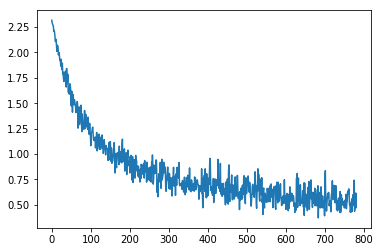

In [19]:
plt.plot(losses)

Let's create a more sophisticated module by adding a second layer

In [21]:
class Mnist_Module(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin1 = nn.Linear(784, 50, bias = 50)
        self.lin2 =  nn.Linear(50, 10, bias = 10)
        
    def forward(self, x):
        
        x = self.lin1(x)
        x = F.relu(x)
        
        return self.lin2(x)

In [22]:
#lets create this module in the gpu

model = Mnist_Module().cuda()

In [23]:
losses = [update(batch, label, lr) for batch, label in data.train_dl]

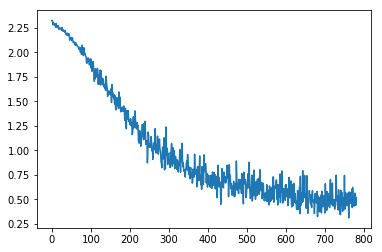

In [24]:
plt.plot(losses)

Lets see how a learner automate this process

In [30]:
learner = Learner(data,Mnist_Module(), loss_func = loss_function,metrics=[accuracy])
print(learner)                                                        

Learner(data=DataBunch;

Train: <torch.utils.data.dataset.TensorDataset object at 0x7f3fe09c2c18>;

Valid: <torch.utils.data.dataset.TensorDataset object at 0x7f3fe09c2a20>;

Test: None, model=Mnist_Module(
  (lin1): Linear(in_features=784, out_features=50, bias=True)
  (lin2): Linear(in_features=50, out_features=10, bias=True)
), opt_func=functools.partial(<class 'torch.optim.adam.Adam'>, betas=(0.9, 0.99)), loss_func=<function cross_entropy at 0x7f3fe7a1a620>, metrics=[<function accuracy at 0x7f3fe0f2d378>], true_wd=True, bn_wd=True, wd=0.01, train_bn=True, path=PosixPath('.'), model_dir='models', callback_fns=[functools.partial(<class 'fastai.basic_train.Recorder'>, add_time=True)], callbacks=[], layer_groups=[Sequential(
  (0): Linear(in_features=784, out_features=50, bias=True)
  (1): Linear(in_features=50, out_features=10, bias=True)
)], add_time=True)


In [31]:
learner.fit_one_cycle(1,max_lr=lr)

epoch,train_loss,valid_loss,accuracy,time
0,0.132546,0.129221,0.961800,00:02


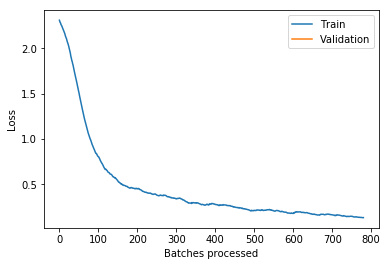

In [32]:
learner.recorder.plot_losses()